In [70]:
dut.disconnect()

Serial port disconnected.


In [ ]:
dut.ground_PIC()

In [634]:
dut.reset_chip()
dut.reset_dpe()

In [67]:
dut.power_off()

In [71]:
%reload_ext autoreload
%autoreload 2

import dut_func as dut
import serial
import time
import struct
import numpy as np
# from bitarray import bitarray
from bitstring import BitArray
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
import dut_a0 as a0

from misc import *

# dut.drv.serUSB = 'COM19'
drv = dut.drv

ser = serial.Serial('COM6', 9600, timeout=1)
dut.connect(ser)


SerialException: could not open port 'COM6': PermissionError(13, 'Access is denied.', None, 5)

In [2]:
dut.power_on()

DAC initialized to a span from -5 V to 5 V


In [3]:
drv.gpio_pin_set('H', 1)

Calibrate all 12 ADCs on A0

In [65]:
ar=1
r=7
c=1

Vreads = np.arange(0, 0.5, 0.01)
# Vgates = np.arange(0,5,0.5)
# Vgates = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 5]
Vgates = [5]

volts_set = []

for Vgate in Vgates:
    print(f'{Vgate:.2f}', end='-')
    volts = []
    for vread in Vreads:
        volts.append( a0.read_single(vread, Vgate, array=ar, row=r, col=c, gain=3) )
    volts_set.append(volts)

5.00-

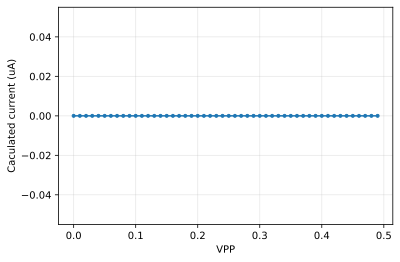

In [66]:
for volts in volts_set:
    plt.plot(Vreads, [i* 1e6 for i in volts], '.-')
    
plt.xlabel('VPP')
plt.ylabel('Caculated current (uA)')
plt.grid(True, alpha=0.3)
# plt.ylim(-0.1, 6)

In [44]:
# Set

def _set(Vset, Vgate):
#     Vset = 1
#     Vgate = 1
    Twidth = 1e-6

    data_load = dut.data_generate_sparse([r, c])
    dut.load_vectors(array=ar, data=data_load)

    dut.pads_defaults()
#     drv.gpio_pin_set(*PIC_PINS['WRT_INTERNAL_EN'])
    drv.gpio_pin_reset(*PIC_PINS['WRITE_ADD_CAP'])
    drv.gpio_pin_set(*PIC_PINS['WRITE_SEL_EXT'])

    dut.reset_dpe()

    dut.dac_set('DAC_VP_PAD', 0)

    drv.gpio_pin_set(*PIC_PINS['WRITE_FWD'])

    drv.gpio_nforce_safe_write(0b1<<ar)

    drv.gpio_pin_set(*PIC_PINS['ROW_WRITE_CONNECT'])
    drv.gpio_pin_set(*PIC_PINS['CONNECT_COLUMN_T'])

    dut.dac_set('P_TVDD', Vgate)
    dut.dac_set('DAC_VP_PAD', Vset)
    time.sleep(Twidth)
    dut.dac_set('DAC_VP_PAD', 0)

    drv.gpio_pin_reset(*PIC_PINS['CONNECT_COLUMN_T'])
    drv.gpio_pin_reset(*PIC_PINS['ROW_WRITE_CONNECT'])
    drv.gpio_nforce_safe_write(0)

In [6]:
# Reset
def _reset(Vreset, Vgate):
#     Vreset = 1
#     Vgate = 5
    Twidth = 1e-6

    data_load = dut.data_generate_sparse([r, c])
    dut.load_vectors(array=ar, data=data_load)

    dut.pads_defaults()
#     drv.gpio_pin_set(*PIC_PINS['WRT_INTERNAL_EN'])

    drv.gpio_pin_reset(*PIC_PINS['WRITE_ADD_CAP'])
    drv.gpio_pin_set(*PIC_PINS['WRITE_SEL_EXT'])
    dut.reset_dpe()

    dut.dac_set('DAC_VP_PAD', 0)
    

    drv.gpio_nforce_safe_write(0b1<<ar)

    drv.gpio_pin_set(*PIC_PINS['COL_WRITE_CONNECT'])
    drv.gpio_pin_set(*PIC_PINS['CONNECT_COLUMN_T'])


    dut.dac_set('DAC_VP_PAD', Vreset)
    time.sleep(Twidth)        # delay(as necessary to write)
    dut.dac_set('DAC_VP_PAD', 0)

    drv.gpio_pin_reset(*PIC_PINS['CONNECT_COLUMN_T'])
    drv.gpio_pin_reset(*PIC_PINS['COL_WRITE_CONNECT'])
    drv.gpio_nforce_safe_write(0)

In [14]:
volts_reset = np.arange(0, 1.5, 0.1)
currs = []

for v_reset in volts_reset:
    _reset(v_reset)
    current = a0.read_single(0.2, 5, array=ar, row=r, col=c, gain=2)
    currs.append(current)

Text(0.5, 0, 'Vreset (V)')

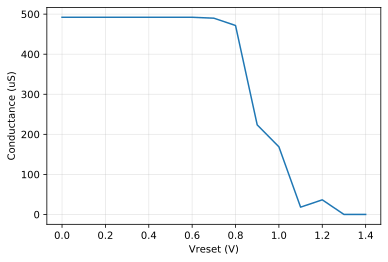

In [20]:
plt.plot(volts_reset, [c/0.2*1e6 for c in currs])
plt.grid(True, alpha=0.3)
plt.ylabel('Conductance (uS)')
plt.xlabel('Vreset (V)')

In [47]:
volts_reset = np.arange(0, 2, 0.1)
currs = []
v_gate = 1

for v_reset in volts_reset:
    _set(v_reset, v_gate)
    current = a0.read_single(0.2, 5, array=ar, row=r, col=c, gain=2)
    currs.append(current)

Text(0.5, 0, 'Vset (V)')

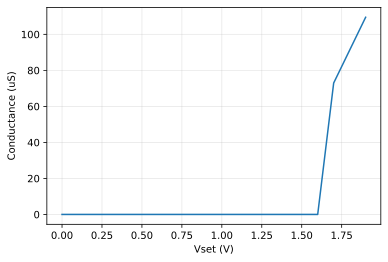

In [53]:
plt.plot(volts_reset, [c/0.2*1e6 for c in currs])
plt.grid(True, alpha=0.3)
plt.ylabel('Conductance (uS)')
plt.xlabel('Vset (V)')

In [63]:
volts_reset = np.append( np.arange(0, -1.5, -0.1),  np.arange(-1.5, 2, 0.1))
volts_reset = np.append(volts_reset,  np.arange(2, 0, -0.1))

currs = []
v_gate = 1

for v_reset in volts_reset:
    if v_reset<0 :
        _reset(v_reset)
    else:
        _set(v_reset, Vgate)
        
    current = a0.read_single(0.1, 5, array=ar, row=r, col=c, gain=2)
    currs.append(current)

Text(0.5, 0, 'Vset (V)')

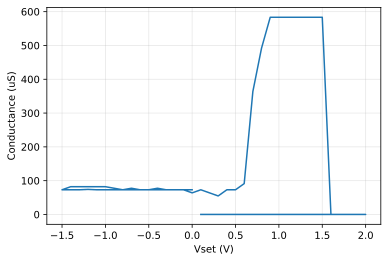

In [64]:
plt.plot(volts_reset, [c/0.1*1e6 for c in currs])
plt.grid(True, alpha=0.3)
plt.ylabel('Conductance (uS)')
plt.xlabel('Vset (V)')

In [62]:
volts_reset

array([ 0.00000000e+00, -1.00000000e-01, -2.00000000e-01, -3.00000000e-01,
       -4.00000000e-01, -5.00000000e-01, -6.00000000e-01, -7.00000000e-01,
       -8.00000000e-01, -9.00000000e-01, -1.00000000e+00, -1.10000000e+00,
       -1.20000000e+00, -1.30000000e+00, -1.40000000e+00, -1.50000000e+00,
       -1.40000000e+00, -1.30000000e+00, -1.20000000e+00, -1.10000000e+00,
       -1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
       -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
       -2.00000000e-01, -1.00000000e-01,  1.33226763e-15,  1.00000000e-01,
        2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
        6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01,
        1.00000000e+00,  1.10000000e+00,  1.20000000e+00,  1.30000000e+00,
        1.40000000e+00,  1.50000000e+00,  1.60000000e+00,  1.70000000e+00,
        1.80000000e+00,  1.90000000e+00,  2.00000000e+00,  1.90000000e+00,
        1.80000000e+00,  